<h1 style='color:red;'> Log Likelihood Ratio 🦄</h1>

<h3> Given two labeled populations with any number of features, maximize the seperation of true positives from false negatives. Here true positives will be defined as Type 1 and false negatives are Type 2 </h3>

In [44]:
from __future__ import division
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

import scipy.stats as stats
from scipy.interpolate import interp2d
import scipy.stats as st
import scipy as sp
import scipy.interpolate as ip
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.interpolate import interp2d

Populating the interactive namespace from numpy and matplotlib


<h3> Supporting functions for this notebook... and some cool plotting tools from my postdoc days</h3>

In [76]:
def scatterColor(x,y,a=0.8,size=8):
    '''Define color Scatter Plot'''
    xy=vstack([x,y])
    xy[isnan(xy)]=0
    xy[isinf(xy)]=0
    z= st.gaussian_kde(xy)(xy)
    plt.scatter(x,y,c=z,s=size,edgecolor='',alpha=a)
    return

def pdfcont(x,y,nsig=3,color='b',fill=True,fill_alpha=0.2, colormap=plt.cm.Reds, xlim=-1, ylim=-1,bins=50,label=True):
    ''' draw n-sigma contours around a population of points '''
    if isinstance(xlim,list):
        xmin=xlim[0]
        xmax=xlim[1]
    else:
        xmin=min(x)
        xmax=max(x)
    if isinstance(ylim,list):
        ymin=ylim[0]
        ymax=ylim[1]
    else:
        ymin=min(y)
        ymax=max(y)
    
    x_range=linspace(xmin,xmax,bins)
    y_range=linspace(ymin,ymax,bins)
    pdf1=stats.kde.gaussian_kde([x,y])
    # create a grid over which we can evaluate pdf
    q,w=np.meshgrid(x_range, y_range)
    r1=pdf1([q.flatten(),w.flatten()])
    # sample the pdf and find the value at the 95th percentile
    sig3=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 0.3)
    sig2=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 5)
    sig1=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 100-68.26)
    per50=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 50)
    per0=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 100)
    # reshape back to 2d
    r1.shape=(size(y_range),size(x_range))

    levels=[sig1,sig2,sig3][:nsig]
    levels.reverse()#levels must increase
    linestyles=['-','--',':'][:nsig]
    linestyles.reverse()
    # plot the contour at the 95th percentile
    
    CS=plt.contour(x_range, y_range, r1, levels,linewidths=3,alpha=1,colors=color, linestyles=linestyles) #
    #plt.contour(x_range, y_range, r1, [sig2],colors='c',linewidths=2)
    #c1=plt.contour(x_range, y_range, r1, [sig1],colors='r',use_clabeltext=True)
    # Recast levels to new class
    CS.levels = ['1$\sigma$','2$\sigma$','3$\sigma$'][:nsig]
    CS.levels.reverse()#levels must increase
    
    #plt.contourf(x_range, y_range, r1,[sig1,per0] ,linewidths=1,alpha=0.5)
    if fill==True:
        #levels.reverse()
        levels.append(per0)
        plt.contourf(x_range, y_range, r1,levels ,linewidths=1,alpha=fill_alpha,cmap=colormap)
    # Label levels with specially formatted floats
    #if plt.rcParams["text.usetex"]:
    #    fmt = r'%r \%%'
    #else:
    #    fmt = '%1.3f %%'
    #    fmt = '%{:} %%'
    if label==True:
        plt.clabel(CS, CS.levels, inline=True, fontsize=20)
    
#input x,y range in the future for selected region 
def pdf_gen(x_var,y_var,x_range_sel,y_range_sel,nbins = 100):
    x_var=np.array(x_var) #first convert to np array for logical cuts
    y_var=np.array(y_var)
    cut= (x_var>=x_range_sel[0]) & (x_var<=x_range_sel[1]) & (y_var>=y_range_sel[0]) & (y_var<=y_range_sel[1])
    x_var=x_var[cut]
    y_var=y_var[cut]
    
    H, xedges, yedges = histogram2d(x_var,y_var, bins=nbins,normed=1)
    H=H.T
    xcenters = xedges[:-1] + diff(xedges[:2])/2
    ycenters = yedges[:-1] + diff(yedges[:2])/2
    #Construct interpolator
    pdf = interp2d(xcenters, ycenters, H, kind='linear')
    x_r=[xedges.min(),xedges.max()]
    y_r=[yedges.min(),yedges.max()]
    
    x_range=linspace(x_range_sel[0],x_range_sel[1],nbins)
    y_range=linspace(y_range_sel[0],y_range_sel[1],nbins)
    # fit a KDE to the data
    pdf=sp.stats.kde.gaussian_kde([x_var,y_var])
    q,w=np.meshgrid(x_range, y_range)
    r1=pdf([q.flatten(),w.flatten()])
    r1.shape=(size(y_range),size(x_range))
    r1=r1/sum(r1) #normalize the pdf
    return r1, x_var, y_var, x_range, y_range

def interpAD(Z,X,Y):
    vals=[]
    for x,y in zip (X,Y):
        vals.append(Z(x,y)[0])
    return np.array(vals)

<h1> Step 1: <br> Define two populations (Type1 and Type2) that depend on features (F1 and F2)</h1>

In [191]:
x_range=[0, 50]
y_range=[0,10.0]

#Type 1 signal (has two features). we will draw from a random distribution about a mean and sigma
meanT1F1,sigmaT1F1=10,5
meanT1F2,sigmaT1F2=10,2

#Type 2 signal (has two features)
meanT2F1,sigmaT2F1=25,5
meanT2F2,sigmaT2F2=20,10

#Create a random sample of 10000 points for T1 and T2 singal with the parameters defined above
T1=np.vstack((np.random.normal(meanT1F1, sigmaT1F1, 10000)+5*np.random.random(10000),np.random.normal(meanT1F2, sigmaT1F2, 10000)))
T2=np.vstack((np.random.normal(meanT2F1, sigmaT2F1, 10000),np.random.normal(meanT2F2, sigmaT2F2, 10000)+5*np.random.random(10000)))

<h3> Make a density scatter plot from the random points generated for Type 1 and Type 2 signals above</h3>

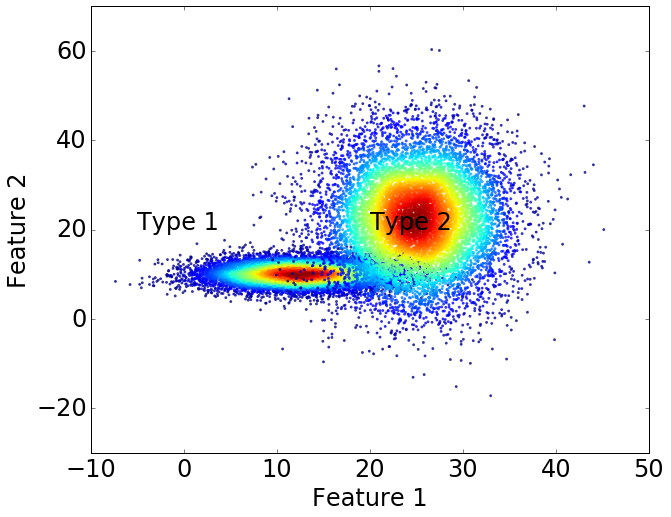

In [192]:
scatterColor(T1[0,:],T1[1,:]) # plotting feature two vs. feature one
scatterColor(T2[0,:],T2[1,:])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.text(-5,20,'Type 1')
plt.text(20,20,'Type 2')

<h1> Given the scatter of labeled points create a PDF for each Type (aka: A normalized histogram) </h1>

In [193]:
# you can keep this binned, it is better to use KDE and create unbinned continual pdfs
#define the range and generate a probability distribution function
x_range=[-10, 50]
y_range=[-20,60]
pdf_Type1, x_T1, y_T1, xx, yy= pdf_gen(T1[0,:], T1[1,:],x_range,y_range)
pdf_Type2, x_T2, y_T2, xx, yy= pdf_gen(T2[0,:], T2[1,:],x_range,y_range)

<h1> Visualize the PDFs generated for the two Types (T1 and T2) </h1>

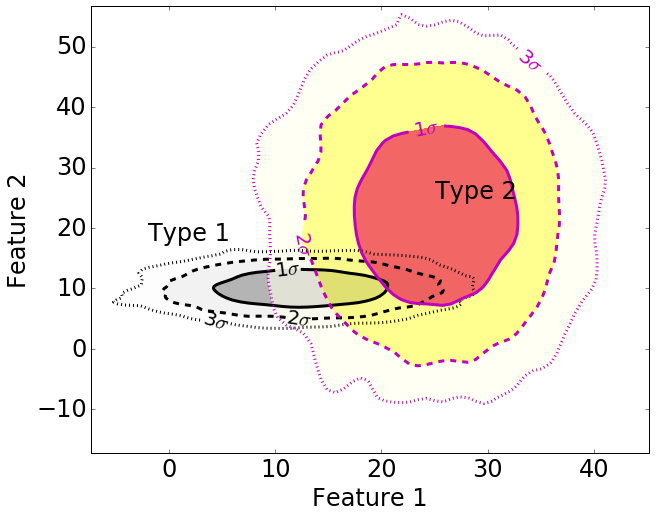

In [194]:
pdfcont(x_T1,y_T1,nsig=3,color='k',fill=True,fill_alpha=0.5, colormap=plt.cm.Greys)
pdfcont(x_T2,y_T2,nsig=3,color='m',fill=True,fill_alpha=0.6, colormap=plt.cm.hot_r)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.text(-2,18,'Type 1')
plt.text(25,25,'Type 2')

<h1> From the two PDFs calculate the Log Likelihood Ratio (LLR) at every point on our feature plane</h1>

In [195]:
LLR=np.log10(pdf_Type2)-np.log10(pdf_Type1) #the log likelihood ratio
LLR[LLR>200]=200 #stop at crazy values ... 10^200 :)
LLR[isinf(LLR)]=200
LLR[isnan(LLR)]=200
Z=interp2d(xx,yy,LLR,kind='linear') #The LLR interpolated on the 2D plane (2D = two features)

/Users/attiladobi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


<h3>Z(Feature1,Feature2) will return the LLR value for every point in our feature space </h3>

<h1> Visualize the LLR at every point on the plane. </h1>

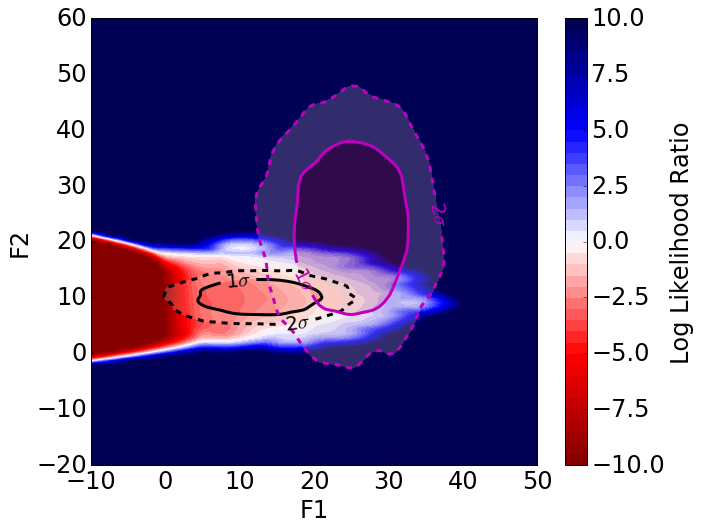

In [126]:
#plot the decision boundry
plt.figure()
LLR_plot=Z(xx,yy)
#set color range dfor plotting, white will be center of 40 GeV WIMP population
LLR_plot[LLR_plot<-10]=-10
LLR_plot[LLR_plot>10]=10
s=np.linspace(-10,10,num=41)
cmap=matplotlib.cm.seismic_r
plt.contourf(xx,yy,LLR_plot,s,cmap=cmap) #listZ[5] is profile of a 40 GeV WIMP\n",
plt.colorbar(label='Log Likelihood Ratio')

#scatterColor(S1_cut_mw40,log10(S2_cut_mw40/S1_cut_mw40))\n",
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

pdfcont(x_T1,y_T1,color='k',nsig=2)
pdfcont(x_T2,y_T2,color='m',nsig=2)

<h3>More negative values tend to be Type 1-like, positive values tend to be Type 2-like. We will use the LLR to define a decision boundry </h3>
<p> Example: Assume a point lands in a region that is Type1 like <br>
Then the liklihood of being Type 1 will be large ~= 1/10. (remember the likihood is the value of the PDF) <br>
Further, the liklihood of being Type 2 will be tiny 1/1000000 <br>
Thus the LLR for that point will be log10(1/1000000)-log10(1/10) = -5 (very signal like) </p>

<h3> Note: The LLR viualized in the above plot is the decision boundry between clasifying Type 1 and Type 2. The beauty of the method is that we are able to collapse N number of features into a signle value. This single value creates a complex contour in our feature space for classification </h3> 

<h2> We have a set of labeled points (T1 and T2). The final step is to histogram of LLR values for each our population types </h2>

<h1> Where the magic happens </h1>

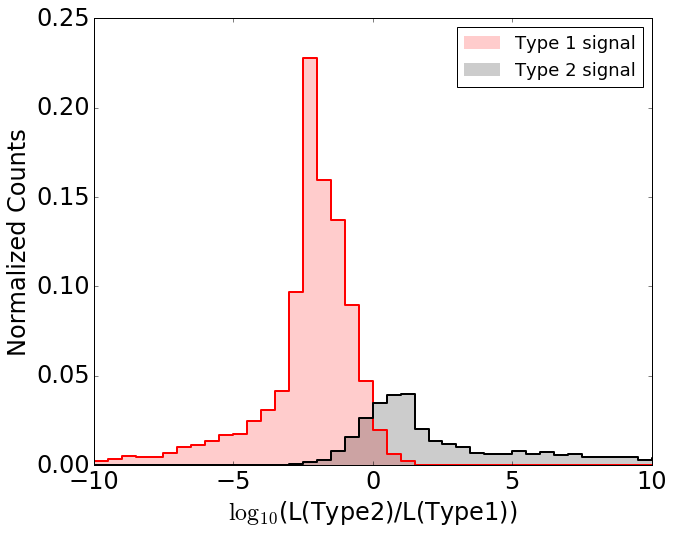

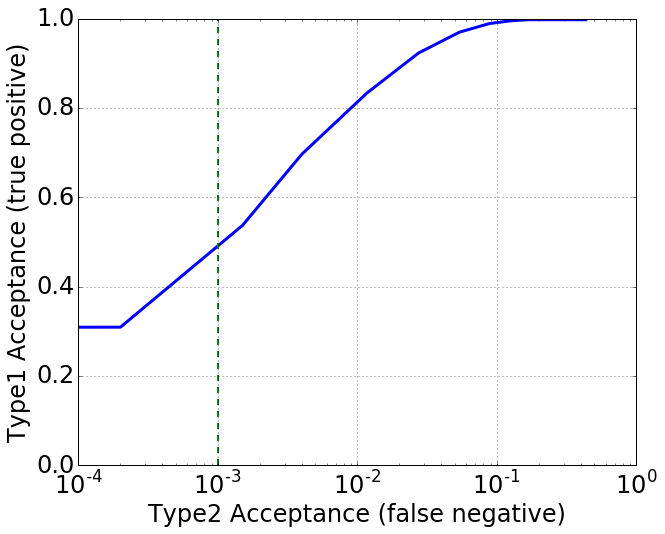

In [198]:
#setup the range of the LLR
width=0.5
xbins=np.arange(-20,40,width)

nLLRT1, edgesT1 = histogram(interpAD(Z,x_T1,y_T1),bins=xbins, normed=0)
nLLRT2, edgesT2= histogram(interpAD(Z,x_T2,y_T2),bins=xbins, normed=0)
nLLRT1=nLLRT1/size(x_T1)
nLLRT2=nLLRT2/size(x_T2)

plt.bar(edgesT1[:-1], nLLRT1 ,alpha=0.2,label='Type 1 signal',color='r',linewidth=0, width=width)
plt.step(edgesT1[1:],nLLRT1,color='r',linewidth=2)
plt.bar(edgesT2[:-1], nLLRT2 ,alpha=0.2,label='Type 2 signal',color='k',linewidth=0, width=width)
plt.step(edgesT2[1:],nLLRT2,color='k',linewidth=2)

xlim([-10,10])
legend(fontsize=18)
xlabel('$\mathrm{log_{10}}$(L(Type2)/L(Type1))')
ylabel('Normalized Counts')

#savefig('figs/MV_Disc_40-8B.png',dpi=200)
#savefig('figs/MV_Disc_40-8B.pdf')

#make figure of cummulative sum... ROC
figure()
T2Frac=cumsum(nLLRT2)
T1Frac=cumsum(nLLRT1)

plot(T2Frac,T1Frac,linewidth=3)
xlabel('Type2 Acceptance (false negative)')
ylabel('Type1 Acceptance (true positive)')
xscale('log')
xscale('log')
xlim([1e-4,1])
ylim([0,1])
grid('on')

plt.plot([1e-3,1e-3],[0,1],'--',linewidth=2)
#plt.plot([5e-3,5e-3],[0,1],'--')
accept_val=T1Frac[np.abs(T2Frac-1e-3).argmin()] #acceptance at 1/1000 rejection
#plt.plot([0,1],[accept_val,accept_val],'--r')
#plt.text(5e-4,accept_val*1.3,'{:1.1f}% Acceptance'.format(accept_val*100))

#savefig('figs/ROC_40.png',dpi=200)
#savefig('figs/ROC_40.pdf')

<h1> The above plot shows that if we vary our decision boundry (which is the LLR) we can reject 1/1000 Type 2 events while accepting about 50% Type 1 events </h1>

<h3> Note: The ROC curve on the bottom is the cummulative sum from left to right of the LLR histogram. It is a measure of how much Type 2 signal will be included as the Type 1 acceptance is incrase</h3>
<p> If the goal is to maximize Type 1 signal then at 99% Type 1 acceptance there will be 10% Type 2 contamination. <br>
If we are interestd in rejecting Type 2 then we can reject 1/1000 Type 2 at the cost of 1/2 of Type 1 acceptance </p>

<h1> That's about all you need to know! :)🦄🦄🦄🦄🦄 </h1>

<h1 style='color:red';> LLR example with multimodal distribuation </h1>

In [164]:
x_range=[0, 50]
y_range=[0,10.0]

#Type 1 signal (has two features)
meanT1F1,sigmaT1F1=10,1
meanT1F2,sigmaT1F2=10,2

#Type 2 signal (has two features)
meanT2F1,sigmaT2F1=25,2
meanT2F2,sigmaT2F2=-5,2

#Type1 and Type two are composed of two features (F1,F2)
T1=np.vstack((np.random.normal(meanT1F1, sigmaT1F1, 10000)+np.random.choice([10,20],10000),np.random.normal(meanT1F2, sigmaT1F2, 10000)))
T2=np.vstack((np.random.normal(meanT2F1, sigmaT2F1, 10000),np.random.normal(meanT2F2, sigmaT2F2, 10000)+np.random.choice([10,20],10000)))

(15, 35)

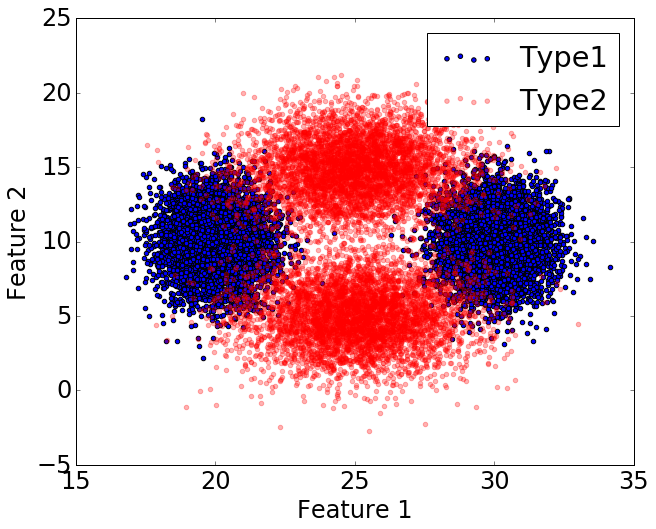

In [186]:
plt.scatter(T1[0,:],T1[1,:])
plt.scatter(T2[0,:],T2[1,:],color='r',alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(('Type1','Type2'),scatterpoints=4)

plt.xlim([15,35])

<h1> generate pdf from distribution (aka normalized histogram) </h1>

In [178]:
#define the range
x_range=[15, 40] #feature 1 range
y_range=[-5,20] #feature 2 range
pdf_Type1, x_T1, y_T1, xx, yy= pdf_gen(T1[0,:], T1[1,:],x_range,y_range)
pdf_Type2, x_T2, y_T2, xx, yy= pdf_gen(T2[0,:], T2[1,:],x_range,y_range)

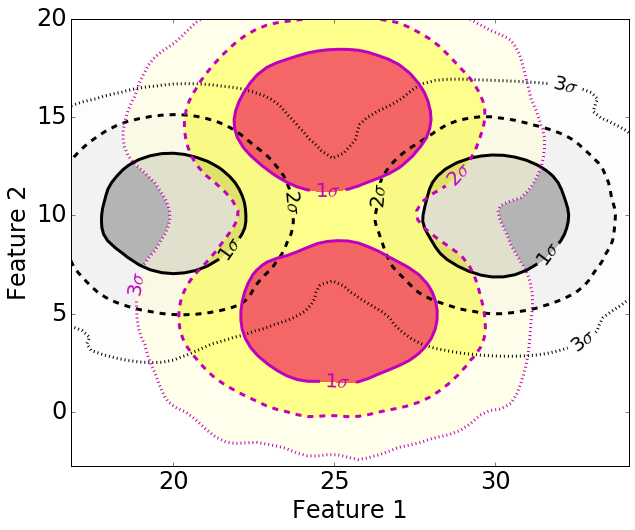

In [179]:
pdfcont(x_T1,y_T1,nsig=3,color='k',fill=True,fill_alpha=0.5, colormap=plt.cm.Greys)
pdfcont(x_T2,y_T2,nsig=3,color='m',fill=True,fill_alpha=0.6, colormap=plt.cm.hot_r)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
#plt.text(-2,18,'Type 1')
#plt.text(25,25,'Type 2')

<h1> Calculate the LLR from the two PDFs </h1>

In [181]:
LLR=np.log10(pdf_Type2)-np.log10(pdf_Type1) #the log likelihood ratio
LLR[LLR>200]=200
LLR[isinf(LLR)]=200
LLR[isnan(LLR)]=200
Z=interp2d(xx,yy,LLR,kind='linear') #The LLR interpolated on the 2D plane (2D = two features)

<h1> Visualize LLR </h1>

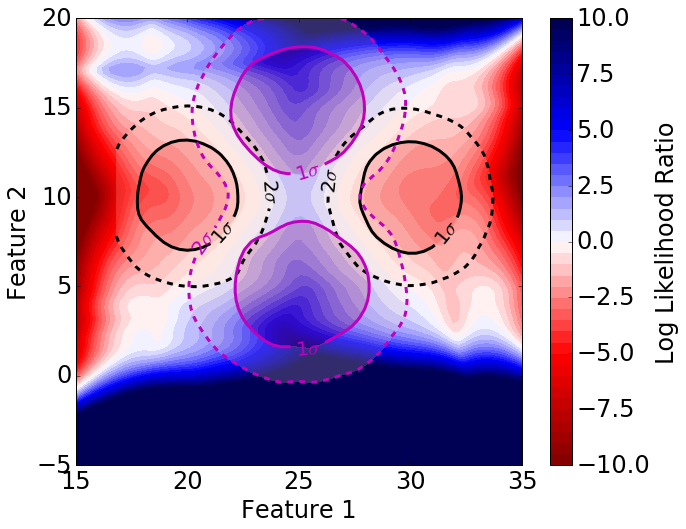

In [185]:
#plot the decision boundry
plt.figure()
LLR_plot=Z(xx,yy)
#set color range dfor plotting, white will be center of 40 GeV WIMP population
LLR_plot[LLR_plot<-10]=-10
LLR_plot[LLR_plot>10]=10
s=np.linspace(-10,10,num=41)
cmap=matplotlib.cm.seismic_r
plt.contourf(xx,yy,LLR_plot,s,cmap=cmap) #listZ[5] is profile of a 40 GeV WIMP\n",
plt.colorbar(label='Log Likelihood Ratio')

#scatterColor(S1_cut_mw40,log10(S2_cut_mw40/S1_cut_mw40))\n",
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.xlim([15,35])


pdfcont(x_T1,y_T1,color='k',nsig=2)
pdfcont(x_T2,y_T2,color='m',nsig=2)

<h1> For every point point (labeled Type 1 and Type 2) create a 1D histogram of LLR </h1>

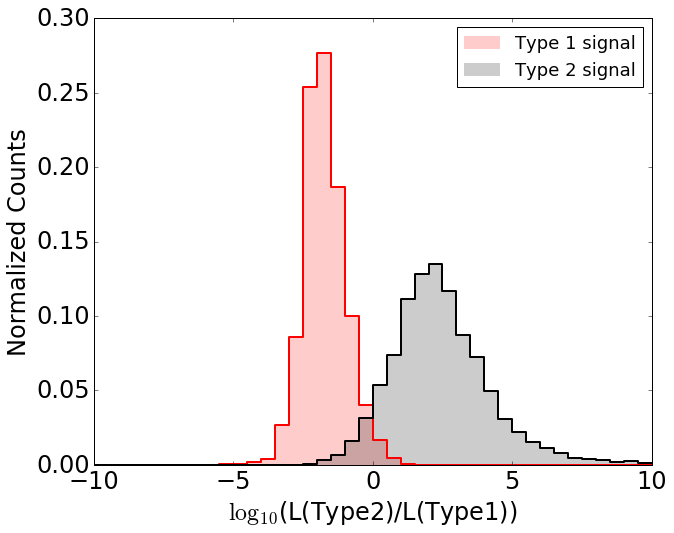

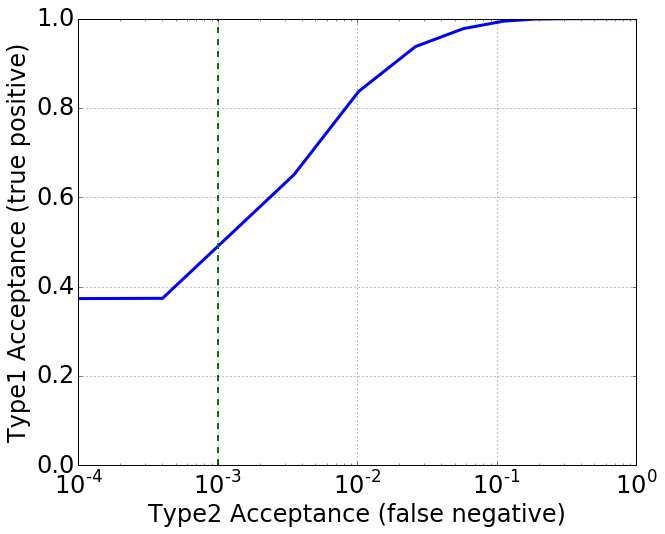

In [183]:
#setup the range of the LLR
width=0.5
xbins=np.arange(-20,40,width)

nLLRT1, edgesT1 = histogram(interpAD(Z,x_T1,y_T1),bins=xbins, normed=0)
nLLRT2, edgesT2= histogram(interpAD(Z,x_T2,y_T2),bins=xbins, normed=0)
nLLRT1=nLLRT1/size(x_T1)
nLLRT2=nLLRT2/size(x_T2)

plt.bar(edgesT1[:-1], nLLRT1 ,alpha=0.2,label='Type 1 signal',color='r',linewidth=0, width=width)
plt.step(edgesT1[1:],nLLRT1,color='r',linewidth=2)
plt.bar(edgesT2[:-1], nLLRT2 ,alpha=0.2,label='Type 2 signal',color='k',linewidth=0, width=width)
plt.step(edgesT2[1:],nLLRT2,color='k',linewidth=2)

xlim([-10,10])
legend(fontsize=18)
xlabel('$\mathrm{log_{10}}$(L(Type2)/L(Type1))')
ylabel('Normalized Counts')

#savefig('figs/MV_Disc_40-8B.png',dpi=200)
#savefig('figs/MV_Disc_40-8B.pdf')

#make figure of cummulative sum... ROC
figure()
T2Frac=cumsum(nLLRT2)
T1Frac=cumsum(nLLRT1)

plot(T2Frac,T1Frac,linewidth=3)
xlabel('Type2 Acceptance (false negative)')
ylabel('Type1 Acceptance (true positive)')
xscale('log')
xscale('log')
xlim([1e-4,1])
ylim([0,1])
grid('on')

plt.plot([1e-3,1e-3],[0,1],'--',linewidth=2)
#plt.plot([5e-3,5e-3],[0,1],'--')
accept_val=T1Frac[np.abs(T2Frac-1e-3).argmin()] #acceptance at 1/1000 rejection
#plt.plot([0,1],[accept_val,accept_val],'--r')
#plt.text(5e-4,accept_val*1.3,'{:1.1f}% Acceptance'.format(accept_val*100))

#savefig('figs/ROC_40.png',dpi=200)
#savefig('figs/ROC_40.pdf')

<h1> Even this multimodal distibution can be converted to a 1D LLR histogram, where the decision boundry is an abstract contour defined by the LLR value </h1>